<a href="https://colab.research.google.com/github/minooshayan97/Empathy_project/blob/main/tuneBERTasCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets wandb

Defaulting to user installation because normal site-packages is not writeable


In [1]:
from datasets import Dataset

import pandas as pd

df = pd.read_csv('Annotated_story_pairs2.csv')
df['text'] = '[CLS]' + df['Shared_stories'] + '[SEP]' + df['Response_strories'] + '[SEP]'
df['label'] = df['Rate']

df = df[['text', 'label']]
ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['text', 'label'],
    num_rows: 804
})

In [2]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

ds = ds.map(lambda x: tokenizer(x['text'],  truncation=True, padding=True))

Map:   0%|          | 0/804 [00:00<?, ? examples/s]

In [3]:
from transformers import DataCollatorWithPadding
import torch

# Rename columns to match what the model expects
ds = ds.rename_column("label", "labels")
ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Define a data collator that dynamically pads batches to the maximum length within the batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='pt')

In [4]:
# Split dataset into train and validation sets
ds = ds.train_test_split(test_size=0.2)
ds_ = ds['test'].train_test_split(test_size=0.5)

train_ds = ds['train']
test_ds = ds_['train']
val_ds = ds_['test']

In [5]:
from torch.utils.data import DataLoader

# Create data loaders for training and validation
train_dataloader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=data_collator)
val_dataloader = DataLoader(val_ds, batch_size=16, collate_fn=data_collator)


In [6]:
from transformers import BertForSequenceClassification

# Load the pre-trained BERT model for sequence classification (regression)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)  # num_labels=1 for regression


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from transformers import AdamW

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)


C:\Users\hai_l\AppData\Roaming\Python\Python39\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
import wandb

# Initialize wandb
wandb.init(
    project="bert-empathy-regression",  # Set your project name here
    config={
        "epochs": 3,
        "batch_size": 16,
        "learning_rate": 2e-5,
        "model_name": "bert-base-uncased"
    }
)


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: minooshayan97 (minoosh). Use `wandb login --relogin` to force relogin


In [9]:
from transformers import get_scheduler
from tqdm import tqdm

# Define the number of epochs
num_epochs = 3

# Set up learning rate scheduler
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Move model to the GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Add wandb to watch the model gradients
wandb.watch(model, log="all", log_freq=10)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_dataloader):
        # Move batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Optimizer step
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        # Accumulate training loss
        total_train_loss += loss.item()

        # Log the training loss to wandb
        wandb.log({"train_loss": loss.item()})

    # Calculate the average training loss for the epoch
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Evaluation at the end of each epoch
    model.eval()
    total_val_loss = 0
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

            # Log the validation loss to wandb
            wandb.log({"Val_loss": loss.item()})

    avg_val_loss = total_val_loss / len(val_dataloader)

    # Log the average training and validation losses to wandb
    wandb.log({
        "epoch": epoch + 1,
        "avg_train_loss": avg_train_loss,
        "avg_val_loss": avg_val_loss
    })

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Finish the wandb run
wandb.finish()


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]C:\Users\hai_l\AppData\Roaming\Python\Python39\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:35<00:00,  1.17it/s]


Epoch 1/3, Train Loss: 0.1591, Validation Loss: 0.0876


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:34<00:00,  1.19it/s]


Epoch 2/3, Train Loss: 0.0967, Validation Loss: 0.0797


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:34<00:00,  1.18it/s]


Epoch 3/3, Train Loss: 0.0923, Validation Loss: 0.0783


Val_loss,▄█▇▇▆▂▄█▇▇▅▁▄█▇▆▅▁
avg_train_loss,█▁▁
avg_val_loss,█▂▁
epoch,▁▅█
train_loss,█▆▁▁▂▁▂▁▂▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁
Val_loss,0.00164
avg_train_loss,0.09225
avg_val_loss,0.07832
epoch,3
train_loss,0.19023


In [77]:
# Disable wandb if you don't want to use it
wandb.init(mode="disabled")


In [78]:
# Move model to the device (CPU or GPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.eval()  # Set the model to evaluation mode

# Create a DataLoader for the tokenized test dataset
test_dataloader = DataLoader(test_ds, batch_size=8, collate_fn=data_collator)

# Function to predict empathy scores for a dataset
def predict_empathy_scores(test_dataloader):
    predictions = []
    for batch in test_dataloader:
        # Move inputs to the appropriate device
        batch = {k: v.to(device) for k, v in batch.items() if k != "labels"}  # Ignore labels if present

        # Make the prediction
        with torch.no_grad():
            outputs = model(**batch)
            empathy_scores = outputs.logits.squeeze().cpu().numpy()  # Get the predicted scores

        predictions.extend(empathy_scores)

    return predictions

# Get predictions for the tokenized test dataset
predicted_scores = predict_empathy_scores(test_dataloader)

In [80]:
predicted_scores

[0.81301093,
 0.4877539,
 0.5479108,
 0.51945585,
 0.64684457,
 0.60004705,
 0.7976854,
 0.55873907,
 0.6344029,
 0.6654223,
 0.5904201,
 0.40737203,
 0.5133482,
 0.44055286,
 0.4414122,
 0.69873786,
 0.544845,
 0.5507084,
 0.38612026,
 0.5649542,
 0.46704325,
 0.47212866,
 0.49647367,
 0.7041731,
 0.66377217,
 0.4927207,
 0.61962587,
 0.45325518,
 0.5388958,
 0.43521792,
 0.54329664,
 0.49708715,
 0.60127527,
 0.4569469,
 0.6754456,
 0.56113464,
 0.5581767,
 0.59130174,
 0.6229515,
 0.6858269,
 0.5640714,
 0.67401737,
 0.76606363,
 0.753791,
 0.56794006,
 0.70716906,
 0.5919356,
 0.48196384,
 0.7767259,
 0.56267345,
 0.53049517,
 0.5553158,
 0.49058348,
 0.5533395,
 0.5373994,
 0.5155756,
 0.72361946,
 0.4379422,
 0.70023996,
 0.63198096,
 0.45059237,
 0.42772004,
 0.44793585,
 0.52973443,
 0.6291927,
 0.5354675,
 0.49829403,
 0.5477609,
 0.48996466,
 0.6229515,
 0.69991416,
 0.51047546,
 0.64674395,
 0.41345087,
 0.5862122,
 0.49391973,
 0.52449673,
 0.55397666,
 0.56384605,
 0.59827

In [84]:
test_ds['labels']

tensor([0.7500, 1.0000, 0.2500, 1.0000, 0.7500, 0.7500, 0.5000, 1.0000, 0.7500,
        0.7500, 1.0000, 0.5000, 0.7500, 0.2500, 1.0000, 0.2500, 0.2500, 1.0000,
        0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.5000, 0.5000, 1.0000,
        0.5000, 0.7500, 1.0000, 0.0000, 0.2500, 0.7500, 0.0000, 0.2500, 0.2500,
        1.0000, 0.5000, 0.5000, 0.5000, 0.7500, 0.7500, 0.7500, 0.5000, 0.5000,
        1.0000, 0.5000, 0.5000, 0.5000, 0.5000, 0.7500, 0.7500, 0.2500, 0.5000,
        0.7500, 0.0000, 1.0000, 0.2500, 0.7500, 0.7500, 0.2500, 0.5000, 0.5000,
        0.7500, 1.0000, 0.7500, 0.5000, 0.0000, 0.7500, 1.0000, 0.7500, 0.7500,
        1.0000, 0.5000, 0.7500, 0.2500, 0.5000, 0.0000, 0.5000, 0.7500])

In [89]:
import torch

# Example predictions and labels (assume both are torch tensors)
predictions = torch.tensor(predicted_scores)  # Example prediction values
labels = torch.tensor(test_ds['labels'])      # Corresponding ground truth labels

# Initialize the Mean Squared Error Loss function
loss_fn = torch.nn.MSELoss()

# Compute the loss between predictions and labels
test_loss = loss_fn(predictions, labels)

print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.0879


C:\Users\hai_l\AppData\Local\Temp\ipykernel_6236\3201186786.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(test_ds['labels'])      # Corresponding ground truth labels


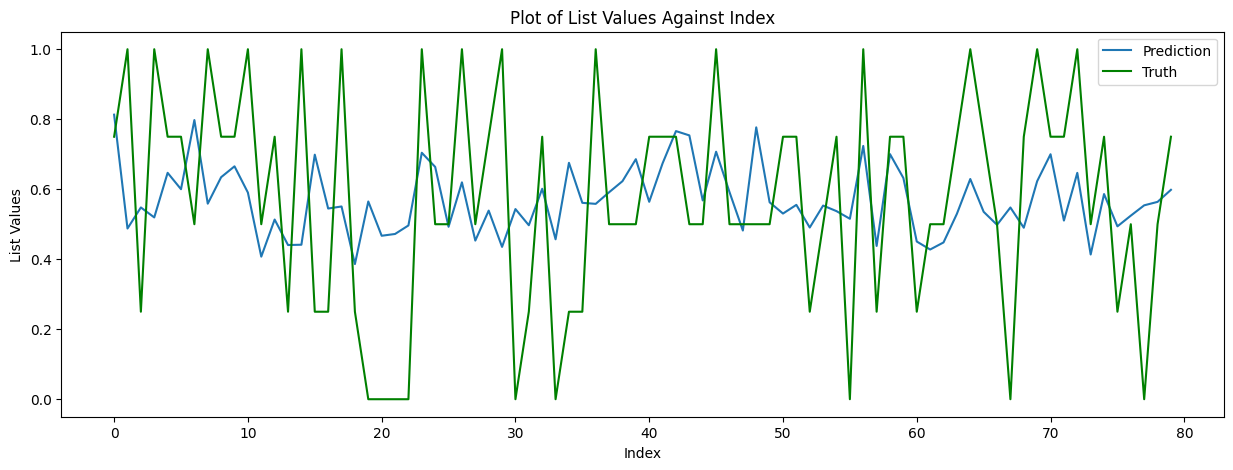

In [86]:
import matplotlib.pyplot as plt


# Set the figure size (width, height in inches)
plt.figure(figsize=(15, 5))

# Plot the first list
plt.plot(predicted_scores, label='Prediction')

# Plot the second list in red
plt.plot(test_ds['labels'], color='green', label='Truth')

# Add labels, title, and a legend
plt.xlabel('Index')
plt.ylabel('List Values')
plt.title('Plot of List Values Against Index')
plt.legend()

# Show the plot
plt.show()

In [90]:
model.save_pretrained('fine_tuned_bert_empathy')
tokenizer.save_pretrained('fine_tuned_bert_empathy')


('fine_tuned_bert_empathy\\tokenizer_config.json',
 'fine_tuned_bert_empathy\\special_tokens_map.json',
 'fine_tuned_bert_empathy\\vocab.txt',
 'fine_tuned_bert_empathy\\added_tokens.json')